In [1]:
# Downloading the FastText Bengali word vectors (300-dimensional) from the official Facebook repository
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.bn.300.vec.gz

# Unzip the downloaded FastText word vector file
!gunzip cc.bn.300.vec.gz

# Listing the details of the unzipped word vector file to verify successful extraction
!ls -lh /content/cc.bn.300.vec

# Importing the Gensim library for loading and working with word vectors
import gensim

# Defining the path to the FastText model file
fasttext_model_path = '/content/cc.bn.300.vec'

# Loading the FastText word vectors using Gensim's KeyedVectors, specifying that the file is in text format (binary=False)
fasttext_model = gensim.models.KeyedVectors.load_word2vec_format(fasttext_model_path, binary=False)

--2024-10-02 14:48:02--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.bn.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.226.210.111, 13.226.210.25, 13.226.210.78, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.226.210.111|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 881274182 (840M) [binary/octet-stream]
Saving to: ‘cc.bn.300.vec.gz’

cc.bn.300.vec.gz    100%[===================>] 840.45M  66.6MB/s    in 11s     

2024-10-02 14:48:14 (74.5 MB/s) - ‘cc.bn.300.vec.gz’ saved [881274182/881274182]

-rw-r--r-- 1 root root 3.2G Jan 18  2019 /content/cc.bn.300.vec


In [2]:
# We are checking each and every constranits to make the BERT model's prediction more accurate

# Install necessary libraries
!pip install transformers torch datasets wordfreq
!pip install tensorflow  # Optional: In case you need TensorFlow

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.0/43.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.3 MB/s eta 0:00:00


In [25]:
#Implementing the complex Word Identification code
# Install necessary libraries
!pip install transformers torch datasets wordfreq
!pip install tensorflow  # Optional: In case you need TensorFlow

from wordfreq import zipf_frequency
import re

# Manual rule-based Bengali syllable counter
def count_syllables(word):
    vowels_check = "অআইঈউঊঋএঐওঔ"
    syllable_count_check = 0
    previous_char_is_vowel1 = False

    # Iterating through each character in the word
    for char in word:
      # Checking if the character is a vowel
        if char in vowels_check:
            # If it's a new vowel sequence, count it as a syllable
            if not previous_char_is_vowel1:
                syllable_count_check += 1
            previous_char_is_vowel1 = True
        else:
            previous_char_is_vowel1 = False
    return syllable_count_check

# Determine if a word is complex based on its frequency
def is_complex_based_on_frequency(word, threshold=3.5):
    frequency = zipf_frequency(word, 'bn')
    return frequency < threshold

# Determine if a word is complex based on its length
def is_complex_based_on_length(word, max_length=8):
    return len(word) > max_length

# Determine if a word is complex based on its syllable count
def is_complex_based_on_syllables(word, max_syllables=3):
    syllable_count_check = count_syllables(word)
    return syllable_count_check > max_syllables

# Split compound words into individual words
def split_compound_words(word):
    return re.split(r'[-\s]', word)

# Hybrid method to identify if a word is complex based on frequency, length, and syllables
def is_complex_word_hybrid(word, frequency_threshold=3.5, critical_frequency=2.5, length_threshold=8, syllable_threshold=3):
    sub_words = split_compound_words(word)
    for sub_word in sub_words:
        if is_complex_based_on_frequency(sub_word, critical_frequency):
            return True
        frequency_check_re = is_complex_based_on_frequency(sub_word, frequency_threshold)
        length_check = is_complex_based_on_length(sub_word, length_threshold)
        syllable_check = is_complex_based_on_syllables(sub_word, syllable_threshold)
        if frequency_check_re and (length_check or syllable_check):
            return True
    return False

# Extract complex words from a given text using the hybrid method
def extract_complex_words_from_file(text):
    complex_words = []
    words = text.split()
    for word in words:
        if is_complex_word_hybrid(word):
            complex_words.append(word)
    return complex_words, text

In [14]:
#Implementing Helper function code

import pandas as pd
import numpy as np
import gensim
import re
from wordfreq import zipf_frequency


# Loading the FastText model for Bengali embeddings (if available)
fasttext_model = gensim.models.KeyedVectors.load_word2vec_format('/content/cc.bn.300.vec')

# 1. Get word vector from FastText
def get_word_vector(word, fasttext_model=None):
    """Fetches the word vector from FastText. Returns None if unavailable."""
    if fasttext_model:
        return fasttext_model.get_vector(word) if word in fasttext_model else None
    return None

# 2. Calculate cosine similarity for semantic similarity check
def calculate_similarity(vector1, vector2):
    if vector1 is None or vector2 is None:
        return 0
    cosine_similarity = np.dot(vector1, vector2) / (np.linalg.norm(vector1) * np.linalg.norm(vector2))
    return cosine_similarity

# 3. Word Frequency check using wordfreq
def get_word_frequency(word):
    return zipf_frequency(word, 'bn')

# 4. Syllable count check for simplicity
def count_syllables(word):
    vowels = "অআইঈউঊঋএঐওঔ"  # Bengali vowels
    syllable_count = 0
    previous_char_is_vowel = False
    for char in word:
        if char in vowels:
            if not previous_char_is_vowel:
                syllable_count += 1
            previous_char_is_vowel = True
        else:
            previous_char_is_vowel = False
    return syllable_count

# 5. Word Familiarity Score (if no dictionary is used, return 0)
def word_familiarity_score(word, familiarity_dict):
    """Fetch familiarity score of the word from a dictionary, returns 0 if unavailable."""
    return familiarity_dict.get(word, 0)

# 6. Compound word splitting
def split_compound_words(word):
    """Split compound words into sub-words."""
    return re.findall(r'\w+', word)

# 7. Lexical simplicity measure
def get_lexical_simplicity(word):
    """Evaluate lexical simplicity."""
    return len(word)  # Placeholder for simplicity evaluation

# 8. Word Polarity check using WordNet (Optional)
def word_polarity(word):
     synsets = wordnet.synsets(word)
     if synsets:
         return synsets[0].lemmas()[0].antonyms()  # Checking polarity
     return None

# Combine all constraints into the helper function
def get_best_candidate(word, word_list, fasttext_model=None, familiarity_dict=None):
    """Select the best candidate word based on multiple constraints."""
    word_vector = get_word_vector(word, fasttext_model)
    best_candidate = None
    best_score = -float('inf')

    # If no familiarity_dict is provided, set to empty dictionary to avoid errors
    familiarity_dict = familiarity_dict if familiarity_dict else {}

    for candidate in word_list:
        candidate_vector_check = get_word_vector(candidate, fasttext_model)
        frequency_score_check = get_word_frequency(candidate)
        similarity_score_check = calculate_similarity(word_vector, candidate_vector_check)
        syllable_score_check = count_syllables(candidate)
        familiarity_score_check = word_familiarity_score(candidate, familiarity_dict)
        #polarity_score = word_polarity(candidate)  # Uncomment if you want polarity check
        lexical_simplicity_score_check = get_lexical_simplicity(candidate)

        # Final score combining various factors
        final_score = (
            0.3 * frequency_score_check +  # Weight to word frequency
            0.2 * similarity_score_check +  # Weight to semantic similarity
            0.1 * syllable_score_check +    # Weight to syllable simplicity
            0.1 * familiarity_score_check + # Weight to familiarity score
            0.1 * lexical_simplicity_score_check  # Weight to lexical simplicity
            # + 0.1 * (1 if polarity_score is None else 0)  # Optional polarity check

        )

        if final_score > best_score:
            best_score = final_score
            best_candidate = candidate

    return best_candidate


In [22]:
# Implementing Simplification code for XLM-Roberta with the assistance of the Helper Function
#Please run the complex word identification script and Helper function script before running this code
#Please run for three Evaluation datasets,Evaluationdataset1, Evaluationdataset2, Evaluationdataset3
#Here writen only for one evaluation dataset as by chnaging file names all three dataset can be run.

from google.colab import files
from transformers import XLMRobertaTokenizer, XLMRobertaForMaskedLM
import torch
import re

# Sentence Splitting Function
def split_text_into_sentences(text):
    sentences = re.split(r'(?<![\u0980-\u09FF]\.\s)(?<=\.|\?|\।)\s', text)
    return sentences

# Substitute Generation using XLM-RoBERTa
def generate_substitutes(tokenizer, model, sentence, complex_word):
    masked_sentence = sentence.replace(complex_word, tokenizer.mask_token)
    inputs = tokenizer(masked_sentence, return_tensors="pt", truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    mask_token_index = torch.where(inputs.input_ids == tokenizer.mask_token_id)[1]
    mask_token_logits = logits[0, mask_token_index, :]
    top_k = torch.topk(mask_token_logits, 5, dim=1).indices[0].tolist()
    return [tokenizer.decode([token]).strip() for token in top_k]

# Substitute Ranking using Helper Function
def rank_substitutes(complex_word, predicted_words, fasttext_model):
    best_word = get_best_candidate(complex_word, predicted_words, fasttext_model)
    return best_word


# Sentence Rewriting Function
def rewrite_sentence(sentence, complex_words, tokenizer, model, fasttext_model):
    for complex_word in complex_words:
        if complex_word in sentence:
            substitutes = generate_substitutes(tokenizer, model, sentence, complex_word)
            best_substitute = rank_substitutes(complex_word, substitutes, fasttext_model)
            if best_substitute:
                sentence = sentence.replace(complex_word, best_substitute)
    return sentence

# File Processing and Simplification
def simplify_document(uploaded_file, tokenizer, model, fasttext_model):
    original_text = uploaded_file.decode('utf-8')  # Decode the uploaded file content
    complex_words, _ = extract_complex_words_from_file(original_text)  # Identify complex words
    sentences = split_text_into_sentences(original_text)  # Split the text into sentences
    simplified_text = ""
    for sentence in sentences:
        simplified_sentence = rewrite_sentence(sentence, complex_words, tokenizer, model, fasttext_model)
        simplified_text += simplified_sentence + " "
    return simplified_text

# Upload and process the file in Google Colab
uploaded = files.upload()
input_filename = list(uploaded.keys())[0]

# Load pre-trained XLM-RoBERTa model and tokenizer
model_name = "xlm-roberta-base"  # XLM-RoBERTa base model
tokenizer = XLMRobertaTokenizer.from_pretrained(model_name)
model = XLMRobertaForMaskedLM.from_pretrained(model_name)

# Run the simplification
simplified_text = simplify_document(uploaded[input_filename], tokenizer, model, fasttext_model)
print("Simplified Text:", simplified_text)

# Download the result
output_file_path = '/content/Robertadataset2withhelp.txt'
with open(output_file_path, 'w', encoding='utf-8') as output_file:
    output_file.write(simplified_text)
files.download(output_file_path)

Saving Evaluationdataset2.txt to Evaluationdataset2.txt


Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForMaskedLM: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Simplified Text: মানবদেহে বিপাকীয় প্রক্রিয়া অত্যন্ত গুরুত্বপূর্ণ, যা বিভিন্ন পুষ্টির পরিবর্তন ঘটিয়ে শক্তি উৎপন্ন করে। 
বিভিন্ন রোগের কারণে দেহে এর ঘাটতি দেখা দেয়। 
ক্যান্সারের চিকিৎসায় একটি থেরাপি প্রায়ই ব্যবহৃত হয়। 
স্টেম সেল থেরাপি অঙ্গ কার সহায়ক। 
অ্যাজমা রোগীদের ফুসফুসে একটি সংকোচন ঘটে, যা হওয়ার কারণ হয়। 
স্বাস্থ্য সক্রিয়তা সংক্রমণ প্রতিরোধে সহায়ক। 
কোষ বিভাজন প্রক্রিয়ায় ত্রুটি ঘটলে ক্যান্সার সৃষ্টি হতে পারে। 
মানসিক রোগের চিকিৎসায় ও কার্যকর হতে পারে। 
অক্সিজেনের অভাবে ক্যান্সার দেখা দিতে পারে, যা শরীরের বিভিন্ন ক্ষতি করে। 
এবং মস্তিষ্কের জটিল অপারেশনে ব্যবহৃত হয়। 
মহাকাশে নক্ষত্রের এক বিস্ফোরণ একটি বিস্ময়কর ঘটনা। 
এই বিকিরণ বিভিন্ন সময় আমাদের জন্য ঝুঁকিপূর্ণ। 
একটি চৌম্বক ক্ষেত্র অত্যন্ত শক্তিশালী, যা বিভিন্ন সময় আপনাকে আকর্ষণ করে। 
দ্বিতীয় প্রান্তে বিভিন্ন সময়ের ধারনা পরিবর্তিত হয়। 
অর্থনৈতিক প্রসারণ গতিতে ডার্ক এনার্জি গুরুত্বপূর্ণ ভূমিকা পালন করে। 
বাংলাদেশের তরঙ্গ মহাকাশের বৃহত্তম প্রাকৃতিক সময় নির্গত হয়। 
সময় ও অবস্থায় কাজ করার জন্য বিশেষ প্রশিক্ষণ প

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [23]:
#Implementing simplification code without the assistance of Helper function for XLM-Roberta
#Please run for three Evaluation datasets,Evaluationdataset1, Evaluationdataset2, Evaluationdataset3
#Here writen only for one evaluation dataset as by chnaging file names all three dataset can be run.

import re
from wordfreq import zipf_frequency
from transformers import XLMRobertaTokenizer, XLMRobertaForMaskedLM
import torch
from google.colab import files

# Manual rule-based Bengali syllable counter
def count_syllables(word):
    vowels = "অআইঈউঊঋএঐওঔ"  # Bengali vowels
    syllable_count = 0
    previous_char_is_vowel = False
    for char in word:
        if char in vowels:
            if not previous_char_is_vowel:
                syllable_count += 1
            previous_char_is_vowel = True
        else:
            previous_char_is_vowel = False
    return syllable_count

# Frequency check with relaxed threshold
def is_complex_based_on_frequency(word, threshold=3.5):
    frequency = zipf_frequency(word, 'bn')
    return frequency < threshold

# Word length check with reduced threshold
def is_complex_based_on_length(word, max_length=8):
    return len(word) > max_length

# Syllable count check with reduced threshold
def is_complex_based_on_syllables(word, max_syllables=3):
    syllable_count = count_syllables(word)
    return syllable_count > max_syllables

# Compound word splitting function
def split_compound_words(word):
    return re.split(r'[-\s]', word)

# Complex word identification function
def is_complex_word_hybrid(word, frequency_threshold=3.5, critical_frequency=2.5, length_threshold=8, syllable_threshold=3):
    sub_words = split_compound_words(word)
    for sub_word in sub_words:
        if is_complex_based_on_frequency(sub_word, critical_frequency):
            return True
        frequency_check = is_complex_based_on_frequency(sub_word, frequency_threshold)
        length_check = is_complex_based_on_length(sub_word, length_threshold)
        syllable_check = is_complex_based_on_syllables(sub_word, syllable_threshold)
        if frequency_check and (length_check or syllable_check):
            return True
    return False

# Sentence Splitting Function
def split_text_into_sentences(text):
    sentences = re.split(r'(?<![\u0980-\u09FF]\.\s)(?<=\.|\?|\।)\s', text)
    return sentences

# Generate alternatives from RoBERTa
def predict_alternatives(tokenizer, model, sentence, complex_word):
    if complex_word not in sentence:
        return []

    masked_sentence = sentence.replace(complex_word, tokenizer.mask_token)
    inputs = tokenizer(masked_sentence, return_tensors="pt", truncation=True, max_length=512)

    if tokenizer.mask_token_id not in inputs.input_ids:
        return []

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    mask_token_index = torch.where(inputs.input_ids == tokenizer.mask_token_id)[1]

    if mask_token_index.nelement() == 0:
        return []

    mask_token_logits = logits[0, mask_token_index, :]
    top_k = 5
    top_k_tokens = torch.topk(mask_token_logits, 5, dim=1).indices[0].tolist()
    predicted_words = [tokenizer.decode([token]).strip() for token in top_k_tokens]

    return predicted_words

# Extract complex words from file
def extract_complex_words_from_file(uploaded_file):
    complex_words = []
    text = uploaded_file.decode('utf-8')
    words = text.split()
    for word in words:
        if is_complex_word_hybrid(word):
            complex_words.append(word)
    return complex_words, text

# Process file and replace complex words using RoBERTa
def replace_complex_words(uploaded_file, output_file_path, tokenizer, model):
    complex_words, original_text = extract_complex_words_from_file(uploaded_file)
    modified_text = original_text

    sentences = split_text_into_sentences(original_text)

    for idx, sentence in enumerate(sentences):
        print(f"Processing sentence {idx+1}/{len(sentences)}: {sentence}")

        for complex_word in complex_words:
            if complex_word in sentence:
                alternatives = predict_alternatives(tokenizer, model, sentence, complex_word)
                if alternatives:
                    modified_text = modified_text.replace(complex_word, alternatives[0])
                else:
                    print(f"Warning: No alternative found for complex word '{complex_word}' in sentence: {sentence}")

    with open(output_file_path, 'w', encoding='utf-8') as output_file:
        output_file.write(modified_text)

    print(f"Modified text with simplified words written to {output_file_path}")
    return output_file_path

# Load RoBERTa model (XLM-RoBERTa for multilingual tasks including Bengali)
def load_roberta_model():
    model_name = "xlm-roberta-base"  # Multilingual RoBERTa that supports Bengali
    tokenizer = XLMRobertaTokenizer.from_pretrained(model_name)
    model = XLMRobertaForMaskedLM.from_pretrained(model_name)
    return tokenizer, model

# Upload the file and process
print("Please upload a text file to process:")
uploaded = files.upload()
input_filename = list(uploaded.keys())[0]

# Load RoBERTa model
tokenizer, model = load_roberta_model()

# Define output file path
output_file_path = '/content/Robertadataset2nohelp.txt'

# Process the uploaded file to replace complex words
replace_complex_words(uploaded[input_filename], output_file_path, tokenizer, model)

# Download the output file
files.download(output_file_path)

Please upload a text file to process:


Saving Evaluationdataset2.txt to Evaluationdataset2 (1).txt


Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForMaskedLM: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Processing sentence 1/41: মানবদেহে বিপাকীয় প্রক্রিয়া অত্যন্ত গুরুত্বপূর্ণ, যা বিভিন্ন পুষ্টির পরিবর্তন ঘটিয়ে শক্তি উৎপন্ন করে।
Processing sentence 2/41: 
বহুমূত্র রোগের কারণে দেহে ইনসুলিনের ঘাটতি দেখা দেয়।
Processing sentence 3/41: 
ক্যান্সারের চিকিৎসায় রেডিয়েশন থেরাপি প্রায়ই ব্যবহৃত হয়।
Processing sentence 4/41: 
স্টেম সেল থেরাপি অঙ্গ পুনর্গঠনে সহায়ক।
Processing sentence 5/41: 
অ্যাজমা রোগীদের ফুসফুসে শ্বাসনালীর সংকোচন ঘটে, যা শ্বাসকষ্টের কারণ হয়।
Processing sentence 6/41: 
অ্যান্টিবডির সক্রিয়তা সংক্রমণ প্রতিরোধে সহায়ক।
Processing sentence 7/41: 
কোষ বিভাজন প্রক্রিয়ায় ত্রুটি ঘটলে ক্যান্সার সৃষ্টি হতে পারে।
Processing sentence 8/41: 
মানসিক রোগের চিকিৎসায় সাইকোথেরাপি কার্যকর হতে পারে।
Processing sentence 9/41: 
অক্সিজেনের অভাবে হাইপোক্সিয়া দেখা দিতে পারে, যা শরীরের কোষগুলির ক্ষতি করে।
Processing sentence 10/41: 
নিউরোসার্জারি মস্তিষ্কের জটিল অপারেশনে ব্যবহৃত হয়।
Processing sentence 11/41: 
মহাকাশে নক্ষত্রের সুপারনোভা বিস্ফোরণ একটি বিস্ময়কর ঘটনা।
Processing sentence 12

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [26]:
#Implementing Simplification code for sagorsarkar with the assistance of the Helper Function
#Please run the complex word identification script and Helper function script before running this code
#Please run for three Evaluation datasets,Evaluationdataset1, Evaluationdataset2, Evaluationdataset3
#Here writen only for one evaluation dataset as by chnaging file names all three dataset can be run.

from google.colab import files
from transformers import BertTokenizer, BertForMaskedLM
import torch
import re

# Sentence Splitting Function
def split_text_into_sentences(text):
    sentences = re.split(r'(?<![\u0980-\u09FF]\.\s)(?<=\.|\?|\।)\s', text)
    return sentences

# Substitute Generation using XLM-RoBERTa
def generate_substitutes(tokenizer, model, sentence, complex_word):
    masked_sentence = sentence.replace(complex_word, tokenizer.mask_token)
    inputs = tokenizer(masked_sentence, return_tensors="pt", truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    mask_token_index = torch.where(inputs.input_ids == tokenizer.mask_token_id)[1]
    mask_token_logits = logits[0, mask_token_index, :]
    top_k = torch.topk(mask_token_logits, 5, dim=1).indices[0].tolist()
    return [tokenizer.decode([token]).strip() for token in top_k]


# Substitute Ranking using Helper Function
def rank_substitutes(complex_word, predicted_words, fasttext_model):
    best_word = get_best_candidate(complex_word, predicted_words, fasttext_model)
    return best_word


# Sentence Rewriting Function
def rewrite_sentence(sentence, complex_words, tokenizer, model, fasttext_model):
    for complex_word in complex_words:
        if complex_word in sentence:
            substitutes = generate_substitutes(tokenizer, model, sentence, complex_word)
            best_substitute = rank_substitutes(complex_word, substitutes, fasttext_model)
            if best_substitute:
                sentence = sentence.replace(complex_word, best_substitute)
    return sentence

# File Processing and Simplification
def simplify_document(uploaded_file, tokenizer, model, fasttext_model):
    original_text = uploaded_file.decode('utf-8')  # Decode the uploaded file content
    complex_words, _ = extract_complex_words_from_file(original_text)  # Identify complex words
    sentences = split_text_into_sentences(original_text)  # Split the text into sentences
    simplified_text = ""
    for sentence in sentences:
        simplified_sentence = rewrite_sentence(sentence, complex_words, tokenizer, model, fasttext_model)
        simplified_text += simplified_sentence + " "
    return simplified_text

# Upload and process the file in Google Colab
uploaded = files.upload()
input_filename = list(uploaded.keys())[0]

# Load pre-trained XLM-RoBERTa model and tokenizer
model_name = "sagorsarker/bangla-bert-base"  # XLM-RoBERTa base model
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForMaskedLM.from_pretrained(model_name)


# Run the simplification
simplified_text = simplify_document(uploaded[input_filename], tokenizer, model, fasttext_model)
print("Simplified Text:", simplified_text)

# Download the result
output_file_path = '/content/sagordataset2withhelp.txt'
with open(output_file_path, 'w', encoding='utf-8') as output_file:
    output_file.write(simplified_text)
files.download(output_file_path)

Saving Evaluationdataset2.txt to Evaluationdataset2 (3).txt


Some weights of the model checkpoint at sagorsarker/bangla-bert-base were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Simplified Text: মানবদেহে বিপাকীয় প্রক্রিয়া অত্যন্ত গুরুত্বপূর্ণ, যা বিভিন্ন পুষ্টির পরিবর্তন ঘটিয়ে শক্তি উৎপন্ন করে। 
বিভিন্ন রোগের কারণে দেহে অক্সিজেনের ঘাটতি দেখা দেয়। 
ক্যান্সারের চিকিৎসায় এবং থেরাপি প্রায়ই ব্যবহৃত হয়। 
স্টেম সেল থেরাপি অঙ্গ এবং সহায়ক। 
অ্যাজমা রোগীদের ফুসফুসে একটি সংকোচন ঘটে, যা মৃত্যুর কারণ হয়। 
এই সক্রিয়তা সংক্রমণ প্রতিরোধে সহায়ক। 
কোষ বিভাজন প্রক্রিয়ায় ত্রুটি ঘটলে ক্যান্সার সৃষ্টি হতে পারে। 
মানসিক রোগের চিকিৎসায় ##ও কার্যকর হতে পারে। 
অক্সিজেনের অভাবে সমস্যা দেখা দিতে পারে, যা শরীরের তাপমাত্রা ক্ষতি করে। 
কিছু মস্তিষ্কের জটিল অপারেশনে ব্যবহৃত হয়। 
মহাকাশে নক্ষত্রের মধ্যে বিস্ফোরণ একটি বিস্ময়কর ঘটনা। 
এই বিকিরণ হচ্ছে সময় ##র জন্য ঝুঁকিপূর্ণ। 
এই চৌম্বক ক্ষেত্র অত্যন্ত শক্তিশালী, যা বিভিন্ন ও শক্তি আকর্ষণ করে। 
অনেক প্রান্তে বিভিন্ন সময়ের ধারনা পরিবর্তিত হয়। 
এই প্রসারণ গতিতে ডার্ক এনার্জি গুরুত্বপূর্ণ ভূমিকা পালন করে। 
কিন্তু তরঙ্গ মহাকাশের বৃহত্তম এর সময় নির্গত হয়। 
কিন্তু ##ার অবস্থায় কাজ করার জন্য বিশেষ প্রশিক্ষণ প্রয়োজন। 
পৃথিবীর মাধ্

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [27]:
#Implementing simplification code without the assistance of Helper function for Sagorsarkar
#Please run for three Evaluation dataset,Evaluationdataset1, Evaluationdataset2, Evaluationdataset3
#Here writen only for one evaluation datasets as by chnaging file names all three dataset can be run.

import re
from wordfreq import zipf_frequency
from transformers import BertTokenizer, BertForMaskedLM
import torch
from google.colab import files

# Manual rule-based Bengali syllable counter
def count_syllables(word):
    vowels = "অআইঈউঊঋএঐওঔ"  # Bengali vowels
    syllable_count = 0
    previous_char_is_vowel = False
    for char in word:
        if char in vowels:
            if not previous_char_is_vowel:
                syllable_count += 1
            previous_char_is_vowel = True
        else:
            previous_char_is_vowel = False
    return syllable_count

# Frequency check with relaxed threshold
def is_complex_based_on_frequency(word, threshold=3.5):
    frequency = zipf_frequency(word, 'bn')
    return frequency < threshold

# Word length check with reduced threshold
def is_complex_based_on_length(word, max_length=8):
    return len(word) > max_length

# Syllable count check with reduced threshold
def is_complex_based_on_syllables(word, max_syllables=3):
    syllable_count = count_syllables(word)
    return syllable_count > max_syllables

# Compound word splitting function
def split_compound_words(word):
    return re.split(r'[-\s]', word)

# Complex word identification function
def is_complex_word_hybrid(word, frequency_threshold=3.5, critical_frequency=2.5, length_threshold=8, syllable_threshold=3):
    sub_words = split_compound_words(word)
    for sub_word in sub_words:
        if is_complex_based_on_frequency(sub_word, critical_frequency):
            return True
        frequency_check = is_complex_based_on_frequency(sub_word, frequency_threshold)
        length_check = is_complex_based_on_length(sub_word, length_threshold)
        syllable_check = is_complex_based_on_syllables(sub_word, syllable_threshold)
        if frequency_check and (length_check or syllable_check):
            return True
    return False

# Sentence Splitting Function
def split_text_into_sentences(text):
    sentences = re.split(r'(?<![\u0980-\u09FF]\.\s)(?<=\.|\?|\।)\s', text)
    return sentences

# Generate alternatives from RoBERTa
def predict_alternatives(tokenizer, model, sentence, complex_word):
    if complex_word not in sentence:
        return []

    masked_sentence = sentence.replace(complex_word, tokenizer.mask_token)
    inputs = tokenizer(masked_sentence, return_tensors="pt", truncation=True, max_length=512)

    if tokenizer.mask_token_id not in inputs.input_ids:
        return []

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    mask_token_index = torch.where(inputs.input_ids == tokenizer.mask_token_id)[1]

    if mask_token_index.nelement() == 0:
        return []

    mask_token_logits = logits[0, mask_token_index, :]
    top_k = 5
    top_k_tokens = torch.topk(mask_token_logits, 5, dim=1).indices[0].tolist()
    predicted_words = [tokenizer.decode([token]).strip() for token in top_k_tokens]

    return predicted_words

# Extract complex words from file
def extract_complex_words_from_file(uploaded_file):
    complex_words = []
    text = uploaded_file.decode('utf-8')
    words = text.split()
    for word in words:
        if is_complex_word_hybrid(word):
            complex_words.append(word)
    return complex_words, text

# Process file and replace complex words using RoBERTa
def replace_complex_words(uploaded_file, output_file_path, tokenizer, model):
    complex_words, original_text = extract_complex_words_from_file(uploaded_file)
    modified_text = original_text

    sentences = split_text_into_sentences(original_text)

    for idx, sentence in enumerate(sentences):
        print(f"Processing sentence {idx+1}/{len(sentences)}: {sentence}")

        for complex_word in complex_words:
            if complex_word in sentence:
                alternatives = predict_alternatives(tokenizer, model, sentence, complex_word)
                if alternatives:
                    modified_text = modified_text.replace(complex_word, alternatives[0])
                else:
                    print(f"Warning: No alternative found for complex word '{complex_word}' in sentence: {sentence}")

    with open(output_file_path, 'w', encoding='utf-8') as output_file:
        output_file.write(modified_text)

    print(f"Modified text with simplified words written to {output_file_path}")
    return output_file_path

# Load RoBERTa model (XLM-RoBERTa for multilingual tasks including Bengali)
def load_roberta_model():
    model_name = "sagorsarker/bangla-bert-base"
    tokenizer = BertTokenizer.from_pretrained(model_name)
    model = BertForMaskedLM.from_pretrained(model_name)
    return tokenizer, model

# Upload the file and process
print("Please upload a text file to process:")
uploaded = files.upload()
input_filename = list(uploaded.keys())[0]

# Load RoBERTa model
tokenizer, model = load_roberta_model()

# Define output file path
output_file_path = '/content/sagordataset2nohelp.txt'

# Process the uploaded file to replace complex words
replace_complex_words(uploaded[input_filename], output_file_path, tokenizer, model)

# Download the output file
files.download(output_file_path)

Please upload a text file to process:


Saving Evaluationdataset2.txt to Evaluationdataset2 (4).txt


Some weights of the model checkpoint at sagorsarker/bangla-bert-base were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Processing sentence 1/41: মানবদেহে বিপাকীয় প্রক্রিয়া অত্যন্ত গুরুত্বপূর্ণ, যা বিভিন্ন পুষ্টির পরিবর্তন ঘটিয়ে শক্তি উৎপন্ন করে।
Processing sentence 2/41: 
বহুমূত্র রোগের কারণে দেহে ইনসুলিনের ঘাটতি দেখা দেয়।
Processing sentence 3/41: 
ক্যান্সারের চিকিৎসায় রেডিয়েশন থেরাপি প্রায়ই ব্যবহৃত হয়।
Processing sentence 4/41: 
স্টেম সেল থেরাপি অঙ্গ পুনর্গঠনে সহায়ক।
Processing sentence 5/41: 
অ্যাজমা রোগীদের ফুসফুসে শ্বাসনালীর সংকোচন ঘটে, যা শ্বাসকষ্টের কারণ হয়।
Processing sentence 6/41: 
অ্যান্টিবডির সক্রিয়তা সংক্রমণ প্রতিরোধে সহায়ক।
Processing sentence 7/41: 
কোষ বিভাজন প্রক্রিয়ায় ত্রুটি ঘটলে ক্যান্সার সৃষ্টি হতে পারে।
Processing sentence 8/41: 
মানসিক রোগের চিকিৎসায় সাইকোথেরাপি কার্যকর হতে পারে।
Processing sentence 9/41: 
অক্সিজেনের অভাবে হাইপোক্সিয়া দেখা দিতে পারে, যা শরীরের কোষগুলির ক্ষতি করে।
Processing sentence 10/41: 
নিউরোসার্জারি মস্তিষ্কের জটিল অপারেশনে ব্যবহৃত হয়।
Processing sentence 11/41: 
মহাকাশে নক্ষত্রের সুপারনোভা বিস্ফোরণ একটি বিস্ময়কর ঘটনা।
Processing sentence 12

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
#Evaluator Script for evaluating the Accuracy, F1 Score, Recall and Precision
#Please run for three Evaluation dataset,Evaluationdataset1, Evaluationdataset2, Evaluationdataset3
# - for all BERT model's result XLM-Roberta and sagorsarkar (with or without helper function)
#Here writen only for one evaluation dataset as by chnaging file names all three evaluation dataset can be run.

import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Step 1: Load the text files
def load_text_file(filepath):
    """Load sentences from a text file."""
    with open(filepath, 'r', encoding='utf-8') as file:
        sentences = file.readlines()
    return [sentence.strip() for sentence in sentences]  # Remove leading/trailing whitespace

# Load files
file1_evaluation = load_text_file('/content/Evaluationdataset1.txt')  # Text file for evaluation sentences
file3_predictions = load_text_file('/content/Robertadataset1withhelp.txt')  # Text file for Roberta's predictions

# Load the ground truth Excel file, with 'sentence', 'complex_words', and 'simplified_words'
file2_ground_truth = pd.read_excel('/content/GrounfTruth1.xlsx')  # Excel file for ground truth data

# Step 2: Parse ground truth file (complex to simple word mapping)
def parse_ground_truth(file2_ground_truth):
    complex_to_simple = {}
    for index, row in file2_ground_truth.iterrows():
        complex_words = row['complex_words']
        simplified_words = row['simplified_words']

        # Skip if either complex_words or simplified_words is missing
        if pd.isna(complex_words) or pd.isna(simplified_words):
            continue

        # Split the complex and simplified words
        complex_words = complex_words.split('/')
        simplified_words = simplified_words.split('/')

        # Map complex words to simplified words (lowercased and stripped)
        for cw, sw in zip(complex_words, simplified_words):
            complex_to_simple[cw.strip().lower()] = sw.strip().lower()

    return complex_to_simple

ground_truth_mapping = parse_ground_truth(file2_ground_truth)

# Step 3: Precision, Recall, F1, and Accuracy for exact complex word replacement
def calculate_precision_recall_f1_accuracy(file1_evaluation, file3_predictions, ground_truth_mapping):
    correct_prediction_labels = []
    true_labels = []

    print("Evaluation in Progress...")

    # Iterate over sentences in both evaluation and prediction files
    for sentence_eval, sentence_pred in zip(file1_evaluation, file3_predictions):
        print(f"Evaluation Sentence: {sentence_eval}")
        print(f"Predicted Sentence: {sentence_pred}")

        sentence_true_labels = []
        sentence_pred_labels = []

        # Identify complex words in the evaluation file and check replacements
        for complex_word, simple_word in ground_truth_mapping.items():
            complex_word = complex_word.lower().strip()
            simple_word = simple_word.lower().strip()

            # Check if the complex word is in the evaluation sentence
            if complex_word in sentence_eval.lower():
                sentence_true_labels.append(1)  # True label: word should be replaced
                print(f"Complex word found: {complex_word}")

                # Check if the complex word is correctly replaced by the simplified word
                if complex_word in sentence_pred.lower():
                    sentence_pred_labels.append(0)  # Complex word is still present in the prediction (wrong)
                    print(f"Complex word still in prediction: {complex_word}")
                elif simple_word in sentence_pred.lower():
                    sentence_pred_labels.append(1)  # Correct replacement made
                    print(f"Simplified word correctly replaced: {simple_word}")
                else:
                    sentence_pred_labels.append(0)  # Simplified word not found (wrong)
                    print(f"Simplified word NOT correctly replaced: {simple_word}")
            else:
                # No replacement needed for this word (True Negative case)
                sentence_true_labels.append(0)
                sentence_pred_labels.append(0)

        # Add the sentence-level labels to the overall label lists
        true_labels.extend(sentence_true_labels)
        correct_prediction_labels.extend(sentence_pred_labels)

    # Check if the lengths are consistent
    if len(true_labels) != len(correct_prediction_labels):
        raise ValueError(f"Inconsistent label lengths: {len(true_labels)} vs {len(correct_prediction_labels)}")

    # Calculate Precision, Recall, F1-score
    precision = precision_score(true_labels, correct_prediction_labels, zero_division=1)
    recall = recall_score(true_labels, correct_prediction_labels, zero_division=1)
    f1 = f1_score(true_labels, correct_prediction_labels, zero_division=1)

    # Calculate Accuracy
    accuracy = accuracy_score(true_labels, correct_prediction_labels)

    return precision, recall, f1, accuracy

# Calculate Precision, Recall, F1, and Accuracy
precision, recall, f1, accuracy = calculate_precision_recall_f1_accuracy(file1_evaluation, file3_predictions, ground_truth_mapping)
print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1-Score: {f1:.2f}, Accuracy: {accuracy:.2f}")


Evaluation in Progress...
Evaluation Sentence: বাংলাদেশ কিংবা যেকোনো দেশেই গণ-অভ্যুত্থানের মাধ্যমে গঠিত সরকার অবশ্যই জনগণের সরকার।
Predicted Sentence: বাংলাদেশ কিংবা যেকোনো দেশেই গণ-অভ্যুত্থানের মাধ্যমে বর্তমান নির্বাচন এবং জনগণের নির্বাচন।
Complex word found: গণ-অভ্যুত্থান
Complex word still in prediction: গণ-অভ্যুত্থান
Evaluation Sentence: এভয়ড রাফা নামে ব্যান্ডের গান শোনার জন্য তাঁরা নিজেদের সমন্বয়ক এবং সাধারণ ছাত্র পরিচয় দেন।
Predicted Sentence: এদিকে রাফা নামে ব্যান্ডের গান শোনার জন্য তাঁরা নিজেদের শিক্ষার্থী এবং সাধারণ ছাত্র পরিচয় দেন।
Evaluation Sentence: এ বিষয়ে জানতে চাইলে বৈষম্যবিরোধী ছাত্র আন্দোলনের কেন্দ্রীয় সমন্বয়ক ও চট্টগ্রাম বিশ্ববিদ্যালয়ের শিক্ষার্থী মোহাম্মদ রাসেল আহমেদ বলেন, তিনি বিষয়টি জানেন না।
Predicted Sentence: এ ব্যাপারে জানতে চাইলে বাংলাদেশের ছাত্র আন্দোলনের কেন্দ্রীয় সম্পাদক ও চট্টগ্রাম বিশ্ববিদ্যালয়ের শিক্ষার্থী মোহাম্মদ রাসেল আহমেদ বলেন, তিনি বিষয়টি জানেন না।
Evaluation Sentence: সব ঠিক থাকলে নিউইয়র্কের স্থানীয় সময় ২৪ সেপ্টেম্বর দুপুরে জাতিসংঘ সদর দপ্তরে ব

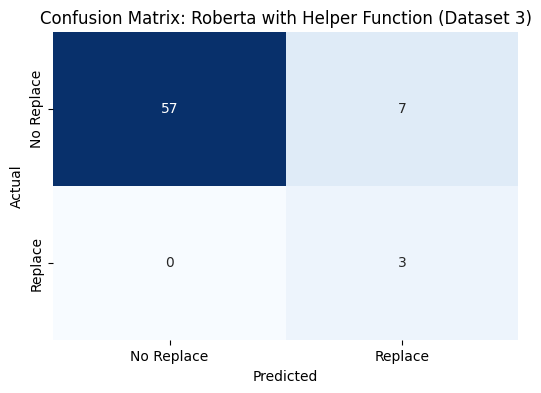

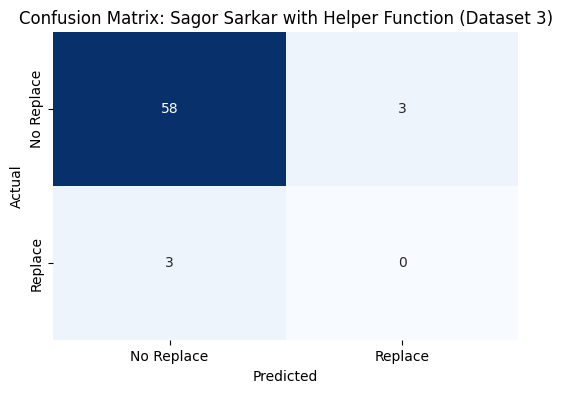

In [1]:
#Code for confusion matrix
# Calculated for XLM-Roberta and Sagorsarkar BERT model with helper functions for Evaluationdataset3
#Rest all variations also can be implemented
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Function to create and display confusion matrix
def create_confusion_matrix(tp, fp, fn, tn, title):
    # Create confusion matrix array
    cm = [[tn, fp], [fn, tp]]

    # Plot the confusion matrix
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['No Replace', 'Replace'], yticklabels=['No Replace', 'Replace'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

# Confusion matrix for Dataset 3 - Roberta with helper function
create_confusion_matrix(3, 7, 0, 57, 'Confusion Matrix: Roberta with Helper Function (Dataset 3)')

# Confusion matrix for Dataset 3 - Sagor Sarkar with helper function
create_confusion_matrix(0, 3, 3, 58, 'Confusion Matrix: Sagor Sarkar with Helper Function (Dataset 3)')